# Predicting Car Prices

### Import and cleaning

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [2]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

In [3]:
cars.head(3)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500


In [4]:
#selecting columns
cols_to_use = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[cols_to_use]

In [5]:
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


In [6]:
#Replacing '?'
numeric_cars = numeric_cars.replace(['?'], np.nan)
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


In [7]:
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  164 non-null    object 
 1   wheel-base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb-weight        205 non-null    int64  
 6   engine-size        205 non-null    int64  
 7   bore               201 non-null    object 
 8   stroke             201 non-null    object 
 9   compression-rate   205 non-null    float64
 10  horsepower         203 non-null    object 
 11  peak-rpm           203 non-null    object 
 12  city-mpg           205 non-null    int64  
 13  highway-mpg        205 non-null    int64  
 14  price              201 non-null    object 
dtypes: float64(5), int64(4), object(6)
memory usage: 24.1+ KB


In [8]:
numeric_cars = numeric_cars.astype(float)

In [9]:
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  164 non-null    float64
 1   wheel-base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb-weight        205 non-null    float64
 6   engine-size        205 non-null    float64
 7   bore               201 non-null    float64
 8   stroke             201 non-null    float64
 9   compression-rate   205 non-null    float64
 10  horsepower         203 non-null    float64
 11  peak-rpm           203 non-null    float64
 12  city-mpg           205 non-null    float64
 13  highway-mpg        205 non-null    float64
 14  price              201 non-null    float64
dtypes: float64(15)
memory usage: 24.1 KB


In [10]:
#Checking nan counts
numeric_cars.isna().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [11]:
# we want to predice price, so we remove rows with price containing NAN
numeric_cars = numeric_cars.dropna(subset=['price'])
# Replace missing values in other columns using column means.
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [12]:
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  201 non-null    float64
 1   wheel-base         201 non-null    float64
 2   length             201 non-null    float64
 3   width              201 non-null    float64
 4   height             201 non-null    float64
 5   curb-weight        201 non-null    float64
 6   engine-size        201 non-null    float64
 7   bore               201 non-null    float64
 8   stroke             201 non-null    float64
 9   compression-rate   201 non-null    float64
 10  horsepower         201 non-null    float64
 11  peak-rpm           201 non-null    float64
 12  city-mpg           201 non-null    float64
 13  highway-mpg        201 non-null    float64
 14  price              201 non-null    float64
dtypes: float64(15)
memory usage: 25.1 KB


In [13]:
keep_price = numeric_cars['price']
numeric_cars = (numeric_cars-numeric_cars.min())/(numeric_cars.max()-numeric_cars.min())
numeric_cars['price'] = keep_price
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


### Applying K Neighbours Regressor

In [14]:
# Model KNeighborsRegressor with default k value
split = 100
def knn_train_test(col_train, col_target, df):
        
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    df_train = df.iloc[:split,:]
    df_test = df.iloc[split:,:]
    knn = KNeighborsRegressor()
    knn.fit(df_train[col_train], df_train[col_target])
    prediction = knn.predict(df_test[col_train])
    mse = mean_squared_error(df_test[col_target], prediction)
    rmse = mse**(1/2)
    return rmse
    

In [15]:
knn_train_test(['normalized-losses'], 'price', numeric_cars)

7330.197653434445

In [16]:
rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

In [17]:
for col in train_cols:
    rmse_val = knn_train_test([col], 'price', numeric_cars)
    rmse_results[col] = rmse_val

In [18]:
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

engine-size          3238.462830
horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64

In [19]:
# Model KNeighborsRegressor with default several k values
def knn_train_test_k(col_train, col_target, df, k):
        
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    df_train = df.iloc[:split,:]
    df_test = df.iloc[split:,:]
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(df_train[col_train], df_train[col_target])
    prediction = knn.predict(df_test[col_train])
    mse = mean_squared_error(df_test[col_target], prediction)
    rmse = mse**(1/2)
    return rmse

In [20]:
knn_train_test_k(['normalized-losses'], 'price', numeric_cars, 2)

6995.131629735551

In [21]:
# Creating dataframe for k_val results
d = {'k_val': [0,0,0,0,0]}
df_results = pd.DataFrame(data=d)
df_results.head()

,k_val
0,0
1,0
2,0
3,0
4,0


In [22]:
# Model KNeighborsRegressor based on k_val results
k_values = [1, 3, 5, 7, 9]
features = cols_to_use[:-1]
inc = 0
for i in k_values :
    df_results['k_val'][inc] = i
    for col in features:
        if inc == 0 : df_results[col] = 0
        result = knn_train_test_k([col], 'price', numeric_cars, i)
        df_results[col][inc] = result
    inc = inc + 1

In [23]:
df_results

,k_val,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg
0,1,7846,4493,4628,4559,8904,5264,3258,8602,9116,8087,4170,9511,5901,6025
1,3,7500,5120,5129,4606,8277,5022,2840,6984,7338,7375,4020,8537,4646,4617
2,5,7330,5461,5427,4704,8144,4401,3238,6780,8006,6610,4037,7697,4766,4630
3,7,7756,5448,5313,4571,7679,4330,3563,6878,7803,6732,4353,7510,5232,4796
4,9,7688,5738,5383,4652,7811,4632,3831,6866,7735,7024,4515,7340,5465,5278


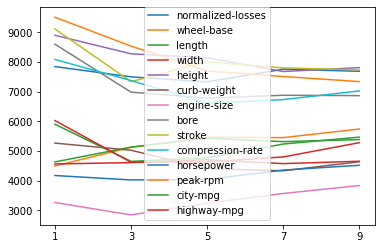

In [24]:
import matplotlib.pyplot as plt
dc = df_results.iloc[:,1:]

plt.plot(dc)
plt.legend(dc.columns)
plt.xticks(range(len(df_results['k_val'])), df_results['k_val'])
dcsummary = pd.DataFrame([dc.mean(), dc.sum()],index=['Mean','Total'])

fig = plt.gcf()

plt.show()

In [25]:
# Model KNeighborsRegressor with all features
def knn_train_test_features(col_train, col_target, df, k):
        
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    df_train = df.iloc[:split,:]
    df_test = df.iloc[split:,:]
    knn = KNeighborsRegressor(n_neighbors = 2)
    knn.fit(df_train[col_train], df_train[col_target])
    prediction = knn.predict(df_test[col_train])
    mse = mean_squared_error(df_test[col_target], prediction)
    rmse = mse**(1/2)
    return rmse

knn_train_test_features(features, 'price', numeric_cars, 2)

3234.3126949803245

In [26]:
# Determine best features
rmse_results_series.sort_values()

engine-size          3238.462830
horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64

In [27]:
features

['normalized-losses',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-size',
 'bore',
 'stroke',
 'compression-rate',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg']

In [28]:
# Model KNeighborsRegressor with n best features
def knn_train_test_n_best(col_train, col_target, df, k):
        
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    df_train = df.iloc[:split,:]
    df_test = df.iloc[split:,:]
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(df_train[col_train], df_train[col_target])
    prediction = knn.predict(df_test[col_train])
    mse = mean_squared_error(df_test[col_target], prediction)
    rmse = mse**(1/2)
    return rmse

In [29]:
n_best = [2,3,4,5]
for j in n_best :
    best = features[:j]
    j_result = knn_train_test_n_best(best, 'price', numeric_cars, 2)
    print('best ' + str(j) + ' features : ' + str(j_result))

best 2 features : 5026.689387954093
best 3 features : 5280.086786246702
best 4 features : 4308.192285324174
best 5 features : 4592.697616168994


In [30]:
# Hyper parameter tuning : 1 to 25 for the best 3 previous models
# The best results were with 2, 4, and 5 best features
n_best = [2,3,4,5]
k2_values = list(range(1,26))

# We create the dataframe of result values 
d2 = {'k_val2': k2_values}
df_results2 = pd.DataFrame(data=d2)
df_results2.head(2)

,k_val2
0,1
1,2


In [31]:
inc = 0
for k2 in k2_values :
    df_results2['k_val2'][inc] = k2
    for j in n_best :
        header_name = str(j)+'best'
        if inc == 0 : 
            df_results2[header_name] = 0
        best = features[:j]
        j_result = knn_train_test_n_best(best, 'price', numeric_cars, k2)
        df_results2[header_name][k2-1] = j_result
        #print('best ' + str(j) + ' features : ' + str(j_result))
    inc = inc + 1

In [32]:
df_results2.head(15)

,k_val2,2best,3best,4best,5best
0,1,5537,4821,4977,5362
1,2,5026,5280,4308,4592
2,3,5485,5385,3841,4312
3,4,5430,5594,3834,4631
4,5,5722,5461,4169,4808
5,6,5584,5281,4595,4809
6,7,5542,5150,4939,4921
7,8,5688,5309,5104,5015
8,9,5801,5421,5082,5104
9,10,5847,5543,5121,5111


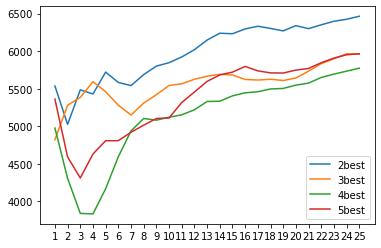

In [33]:
dc2 = df_results2.iloc[:,1:]

plt.plot(dc2)
plt.legend(dc2.columns)
plt.xticks(range(len(df_results2['k_val2'])), df_results2['k_val2'])
dcsummary = pd.DataFrame([dc2.mean(), dc2.sum()],index=['Mean','Total'])

fig = plt.gcf()

plt.show()